# **By Mohamed Ali**

### **Import the liberaries**




In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [95]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### **Reading data and EDA**

In [96]:
# Reading the data 
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [97]:
# Adding a "Category" column to "fake" and "true" datasets to determine 
# the fake from true news in the merged dataset
# 1 ==> Fake
# 0 ==> True

fake['Category'] = 1
true['Category'] = 0

In [98]:
# Merging the 2 datasets into a big labeled one
data = pd.concat([true, fake], ignore_index=True)
data

,title,text,subject,date,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   Category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


#### We can see that there is no null values, but we will need to deal with the object data type before feeding into the model.


In [100]:
# Counts the number of the fake and the true news
data['Category'].value_counts()

1    23481
0    21417
Name: Category, dtype: int64

### **Plotting for some insights**

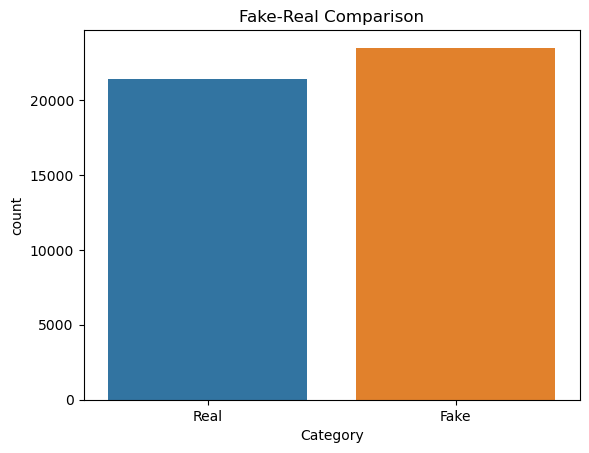

In [101]:
sns.countplot(x="Category", data=data)
plt.title("Fake-Real Comparison")
plt.xlabel("Category")
plt.xticks([1, 0], ["Fake", "Real"])
plt.show()

#### We can see that the data is quiet balanced

In [102]:
# Extracting the year
data['year'] = data['date'].str.split(",").str[1]
# Dropping NaN values from the data that may be produced by extracting the year above
data = data.dropna()
# Converting year from str to int
data.year = data.year.astype(int)

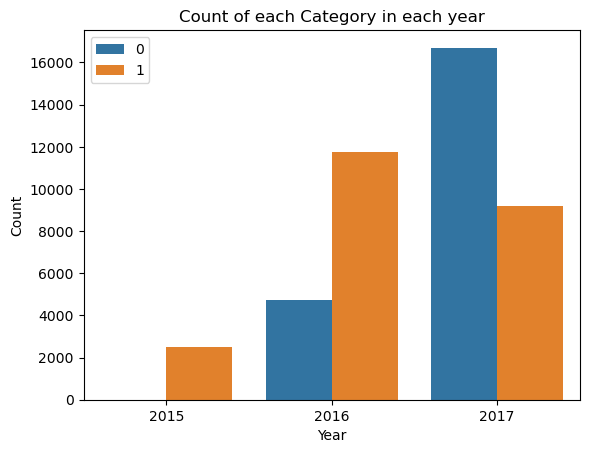

In [129]:
counts_year = data.groupby([pd.to_datetime(data['date']).dt.year, 'Category']).size().reset_index(name='counts')
#print(counts)
# Create a bar plot
sns.barplot(x="date", y='counts', hue='Category', data=counts_year)
plt.legend(loc='upper left')
plt.title("Count of each Category in each year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

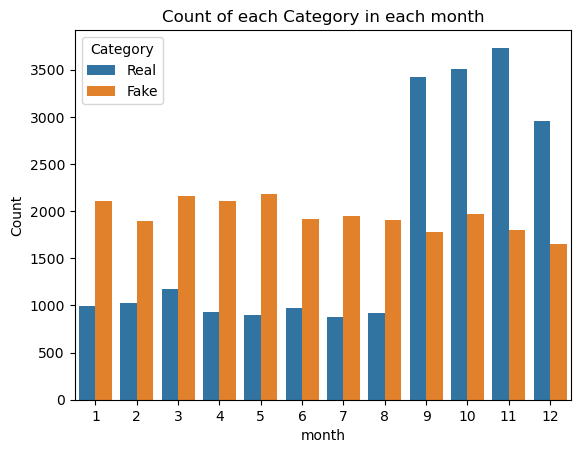

In [131]:
counts_month = data.groupby([pd.to_datetime(data['date']).dt.month, 'Category']).size().reset_index(name='counts')
# Create a bar plot
sns.barplot(x="date", y='counts', hue=counts_month['Category'].map({0: 'Real', 1: 'Fake'}), data=counts_month)
ax.legend(loc='upper left')
plt.title("Count of each Category in each month")
plt.xlabel("month")
plt.ylabel("Count")
plt.show()

#### We can see that all of the information for the year 2015 in the dataset is fake news, and the fake news is much more than the real news in 2016.
#### The amount of fake news is higher until month 8, after which the amount of real news increases drastically. It essentially means that if the month is <=8, then the probability of the news being fake news is higher.

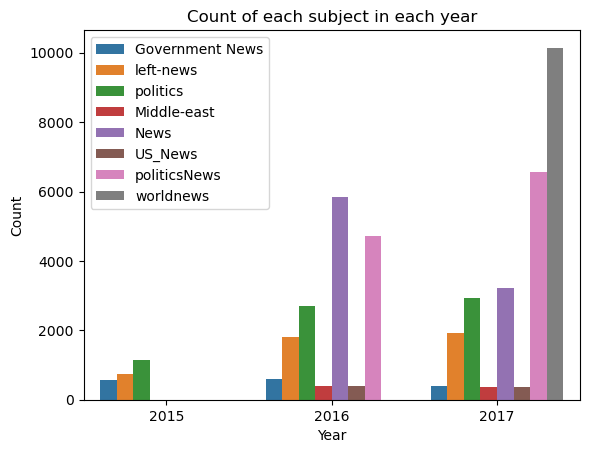

In [109]:
counts_subject_year = data.groupby([pd.to_datetime(data['date']).dt.year, 'subject']).size().reset_index(name='counts')
# Create a bar plot
ax = sns.barplot(x="date", y='counts', hue='subject', data=counts_subject_year)
ax.legend(loc='upper left')
plt.title("Count of each subject in each year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

#### From the plot, we can see that the highest count is for worldNews in 2017, with a count of approximately 10,000. 
#### The lowest count is for Middle-East and US_News in 2016, 2017 with a count of approximately 500. 
#### The counts for Government News and left_news increased from 2015 to 2016 and slightly increased in 2017. 

### **Preprocessing steps**

In [134]:
# First we will  drop the unwanted features
data = data.drop(["title", "date", "subject", "year"], axis=1)
data

,text,Category
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,1
44894,21st Century Wire says It s a familiar theme. ...,1
44895,Patrick Henningsen 21st Century WireRemember ...,1
44896,21st Century Wire says Al Jazeera America will...,1


In [135]:
# Doing some shuffling to the data
data = data.sample(frac = 1)

In [136]:
# Creating a function to process the text
import re, string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [137]:
# processing the text column
data["text"] = data["text"].apply(wordopt)
data

,text,Category
16538,beijing reuters china s ruling communist p...,0
40039,just two months shy of the one year anniversar...,1
32232,israeli first lady sara netanyahu i talk ever...,1
7591,nuevo laredo mexico reuters glafiro monte...,0
28212,for more than seven years now the right wing l...,1
...,...,...
11136,des moines reuters an influential conserva...,0
2509,lowellville ohio reuters on a sweltering ...,0
3010,washington reuters u s president donald t...,0
10945,washington reuters barack obama might seem...,0


In [138]:
import nltk
from nltk.stem import PorterStemmer

In [140]:
from nltk.stem import PorterStemmer

# Initialize the stemmer
stemmer = PorterStemmer()

# Define a function to perform stemming on a line of text
def stem_line(line):
    # Split the line into words
    words = line.split()
    
    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a line
    return ' '.join(stemmed_words)

# Perform stemming on each line of text in the 'text' column
data['stemmed_text'] = data['text'].apply(stem_line)


In [141]:
data

,text,Category,stemmed_text
16538,beijing reuters china s ruling communist p...,0,beij reuter china s rule communist parti broke...
40039,just two months shy of the one year anniversar...,1,just two month shi of the one year anniversari...
32232,israeli first lady sara netanyahu i talk ever...,1,isra first ladi sara netanyahu i talk everi pl...
7591,nuevo laredo mexico reuters glafiro monte...,0,nuevo laredo mexico reuter glafiro montemayor ...
28212,for more than seven years now the right wing l...,1,for more than seven year now the right wing lo...
...,...,...,...
11136,des moines reuters an influential conserva...,0,de moin reuter an influenti conserv magazin pu...
2509,lowellville ohio reuters on a sweltering ...,0,lowellvil ohio reuter on a swelter even in a r...
3010,washington reuters u s president donald t...,0,washington reuter u s presid donald trump urg ...
10945,washington reuters barack obama might seem...,0,washington reuter barack obama might seem an u...


In [142]:
# Splitting the data
X = data["stemmed_text"]
y = data['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

### Model training and evaluation

In [143]:
# Vectorization for a text
from sklearn.feature_extraction.text import TfidfVectorizer
victorizer = TfidfVectorizer()
XV_train = victorizer.fit_transform(X_train)
XV_test = victorizer.transform(X_test)

In [146]:
# Using Random Forest as our model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
# Fit the model on the training data

scores = cross_val_score(model, XV_train, y_train, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Average score: {scores.mean():.2f}')

Cross-validation scores: [0.9864846  0.98676327 0.98899108 0.98634337 0.98634337]
Average score: 0.99


In [148]:
model.fit(XV_train, y_train)
y_pred = model.predict(XV_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9906364953739828

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4310
           1       0.99      0.99      0.99      4661

    accuracy                           0.99      8971
   macro avg       0.99      0.99      0.99      8971
weighted avg       0.99      0.99      0.99      8971



# End of the task